In [1]:
#!pip install datasets

In [2]:
## Please install torch and datasets
import torch
from torchvision.transforms import functional as t
import torch.nn.functional as f
from datasets import load_dataset
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
## Loading our dataset
ds = load_dataset("ylecun/mnist")

In [4]:
## Data splits

X_train_p = ds["train"]["image"]
Y_train = ds["train"]["label"]
X_test_p = ds["test"]["image"]
Y_test = ds["test"]["label"]

In [5]:
## PIL to Tensors

X_train = [t.pil_to_tensor(x) for x in X_train_p]
X_test = [t.pil_to_tensor(x) for x in X_test_p]
X_train = torch.stack(X_train).to(device)
X_test = torch.stack(X_test).to(device)
print(X_train.shape, X_test.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


In [6]:
## Fixing the shape

X_train = X_train.view(-1, 28, 28)
X_test = X_test.view(-1, 28, 28)
print(X_train.shape, X_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [7]:
## Making labels into tensors

Y_train = torch.tensor(Y_train).to(device)
Y_test = torch.tensor(Y_test).to(device)

In [8]:
## Flattening the image as DNN takes flat tensor as input

X_train = X_train.view(-1, 784).float() / 255.0
X_test = X_test.view(-1, 784).float() / 255.0
print(X_train.shape, X_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


In [9]:

import numpy as np
from numpy.linalg import svd



class Linear():
  def __init__(self, input_dims, output_dims, B=True, last=False):
    self.training = True
    self.W = (torch.randn(input_dims, output_dims) * (5/3) / (input_dims**0.5)).to(device) if not last else (torch.randn(input_dims, output_dims) * (5/3) / (input_dims**0.5) * 0.1).to(device)
    if B: self.B = torch.randn(output_dims).to(device) if not last else (torch.randn(output_dims) * 0.1).to(device)
    else: self.B = torch.tensor([]).to(device)

  def __call__(self, x):
    if not torch.equal(self.B, torch.tensor([]).to(device)): self.result = x@self.W + self.B
    else: self.result = x@self.W
    return self.result

  def parameters(self):
    return [self.W] + [self.B]


class Tanh():
  def __init__(self):
    self.training = True
    return None

  def __call__(self, x):
    self.result = torch.tanh(x)
    return self.result

  def parameters(self):
    return []

class Dropout():
  def __init__(self, batch_size, output_dims, rate=0.9):
    self.training = True
    self.rate = rate
    self.factor = (torch.rand(batch_size, output_dims) < self.rate).int().to(device)
    return None

  def __call__(self, x):
    if self.training: self.result = x * self.factor
    else: self.result = x
    return self.result

  def parameters(self):
    return []


def decomposition(A, k=1):

    # SVD
    U, S, VT = svd(A, full_matrices=False)


    # Truncate to rank-k
    U_k = U[:, :k]                # (784 x k)
    S_k = np.diag(S[:k])          # (k x k)
    VT_k = VT[:k, :]              # (k x 10)

    # Factor A_k = L @ R, where L and R are low-rank factors
    sqrt_S_k = np.sqrt(S_k)       # (k x k)
    L = U_k @ sqrt_S_k            # (784 x k)
    R = sqrt_S_k @ VT_k           # (k x 10)

    L_flat = L.flatten()
    R_flat = R.flatten()
    LR_concat = np.concatenate([L_flat, R_flat])

    return LR_concat


In [20]:
batch_size = 60000

mid_dims = 7840*2

W_u1 = (torch.randn(7840, mid_dims) * (5/3) / (7840**0.5)).to(device)
W_u2 = (torch.randn(mid_dims, 7840) * (5/3) / (mid_dims**0.5)).to(device)
W_p_t_1 = (torch.randn(784, 10) * (5/3) / (784**0.5)).to(device)

W_u1.requires_grad = True
W_u2.requires_grad = True
W_p_t_1.requires_grad = False

updaterparams = [W_u1, W_u2]

print(f"Updater parameters: {W_u1.numel() + W_u2.numel()}, Predictor parameters: {W_p_t_1.numel()}")



Updater parameters: 245862400, Predictor parameters: 7840


In [21]:
## Training loop for updater and predictor
iters = 4000
alpha = 0.008
sf = 0.01
losses = []

for c in range(iters):
    # Zero updater gradients
    for p in updaterparams:
        if p.grad is not None:
            p.grad.zero_()

    # Zero predictor gradients
    if W_p_t_1.grad is not None:
        W_p_t_1.grad.zero_()

    W_p_t_detached = W_p_t_1.detach()
    flat_W_p_t_detached = W_p_t_detached.view(-1)
    x = torch.tanh(flat_W_p_t_detached @ W_u1)
    flat_W_p_t_1 = torch.tanh(x @ W_u2)
    W_p_t_1_change = flat_W_p_t_1.view(784, 10)
    W_p_t_1 = W_p_t_detached - sf*W_p_t_1_change

    Y_p_t_1 = torch.tanh(X_train @ W_p_t_1)
    loss = f.cross_entropy(Y_p_t_1, Y_train)

    loss.backward()

    for p in updaterparams:
        p.data -= alpha * p.grad

    if c % (iters // 50) == 0:
        print(f"Iteration {c:4d}, Loss: {loss.item():.6f}")
        losses.append(loss.item())



Iteration    0, Loss: 2.389689


/tmp/ipykernel_459145/913060535.py:14: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if W_p_t_1.grad is not None:


Iteration   80, Loss: 2.072448
Iteration  160, Loss: 1.895862
Iteration  240, Loss: 1.804197
Iteration  320, Loss: 1.748499
Iteration  400, Loss: 1.692848
Iteration  480, Loss: 1.652658
Iteration  560, Loss: 1.628917
Iteration  640, Loss: 1.613734
Iteration  720, Loss: 1.602830
Iteration  800, Loss: 1.595745
Iteration  880, Loss: 1.591500
Iteration  960, Loss: 1.589394
Iteration 1040, Loss: 1.586077
Iteration 1120, Loss: 1.583449
Iteration 1200, Loss: 1.580690
Iteration 1280, Loss: 1.576643
Iteration 1360, Loss: 1.571347
Iteration 1440, Loss: 1.565138
Iteration 1520, Loss: 1.559488
Iteration 1600, Loss: 1.554419
Iteration 1680, Loss: 1.549219
Iteration 1760, Loss: 1.544573


KeyboardInterrupt: 

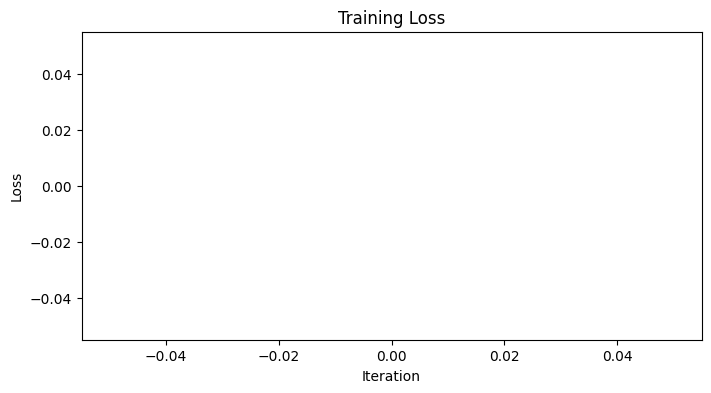

In [16]:
import os

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

# Get current notebook filename and save as PNG
notebook_path = 'model_descent_weight_enc_dec__change_compression_3920_4000it'
filename = os.path.splitext(notebook_path)[0] + '.png'
plt.savefig(filename)
plt.show()

In [19]:
def accuracy(X, Y):
    x = torch.tanh(X @ W_p_t_1)
    probs = f.softmax(x, 1)
    answers = x.argmax(1)
    c = 0
    for a, y in zip(answers, Y):
        if a==y: c+=1
    return c / answers.shape[0] * 100

def loss(X, Y):
    x = torch.tanh(X @ W_p_t_1)
    return f.cross_entropy(x, Y)

print(f"train accuracy: {accuracy(X_train, Y_train)} | test accuracy: {accuracy(X_test, Y_test)}")
print(f"train loss: {loss(X_train, Y_train)} | test loss: {loss(X_test, Y_test)}")

train accuracy: 11.158333333333333 | test accuracy: 10.73
train loss: 2.383404016494751 | test loss: 2.394136428833008


In [14]:
batch_size = 60000

mid_dims = 3920

W_u1 = (torch.randn(7840, 1) * (5/3) / (7840**0.5)).to(device)
W_u2 = (torch.randn(1, 7840) * (5/3) / (392**0.5)).to(device)
W_p_t_1 = (torch.randn(784, 10) * (5/3) / (784**0.5)).to(device)

W_u1.requires_grad = True
W_u2.requires_grad = True
W_p_t_1.requires_grad = False

updaterparams = [W_u1, W_u2]

print(f"Updater parameters: {W_u1.numel() + W_u2.numel()}, Predictor parameters: {W_p_t_1.numel()}")

losses = []

Updater parameters: 15680, Predictor parameters: 7840
